In [1]:
# IMPORT LIBRARY
import os
import time
import random
import numpy as np
import tensorflow as tf
from PIL import Image

from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# PARAMETER GLOBAL & SEED
FINAL_DATASET = "D:/KULIAH/SEMESTER 7/Skripsi/Dataset/Dataset_TrashNet_Final"

CLASSES = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-4
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# DATA GENERATOR (RESCALE ONLY)
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data = train_gen.flow_from_directory(
    os.path.join(FINAL_DATASET, "train"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_data = val_test_gen.flow_from_directory(
    os.path.join(FINAL_DATASET, "val"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

test_data = val_test_gen.flow_from_directory(
    os.path.join(FINAL_DATASET, "test"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 2001 images belonging to 6 classes.
Found 377 images belonging to 6 classes.
Found 383 images belonging to 6 classes.


In [4]:
# MODEL MOBILENETV3 LARGE
base_model = MobileNetV3Large(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze feature extractor
base_model.trainable = False

In [5]:
# Build model (APPLE TO APPLE)
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation="relu"),
    Dense(len(CLASSES), activation="softmax")
])

# COMPILE MODEL
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 64)                61504     
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 3058246 (11.67 MB)
Trainable params: 61894 (241.77 KB)
Non-trainable params: 2996352 (11.43 MB)
_________________________________________________________________


In [6]:
# EARLY STOPPING
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [7]:
# TRAINING + TIME MEASUREMENT
start_time = time.time()

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    verbose=1
)

end_time = time.time()

total_training_time = end_time - start_time
epochs_ran = len(history.history["loss"])

print(f"\nTotal Training Time : {total_training_time:.2f} seconds")
print(f"Average / Epoch    : {total_training_time / epochs_ran:.2f} seconds")
print(f"Training stopped at epoch : {epochs_ran}")

Epoch 1/20


63/63 [==============================] - 16s 198ms/step - loss: 1.6045 - accuracy: 0.3653 - val_loss: 1.3380 - val_accuracy: 0.5252
Epoch 2/20
63/63 [==============================] - 12s 184ms/step - loss: 1.0992 - accuracy: 0.6452 - val_loss: 1.0159 - val_accuracy: 0.6393
Epoch 3/20
63/63 [==============================] - 11s 177ms/step - loss: 0.8324 - accuracy: 0.7361 - val_loss: 0.8275 - val_accuracy: 0.7241
Epoch 4/20
63/63 [==============================] - 11s 178ms/step - loss: 0.6753 - accuracy: 0.7841 - val_loss: 0.7200 - val_accuracy: 0.7692
Epoch 5/20
63/63 [==============================] - 11s 177ms/step - loss: 0.5763 - accuracy: 0.8151 - val_loss: 0.6639 - val_accuracy: 0.7851
Epoch 6/20
63/63 [==============================] - 11s 177ms/step - loss: 0.5075 - accuracy: 0.8366 - val_loss: 0.6194 - val_accuracy: 0.7931
Epoch 7/20
63/63 [==============================] - 11s 180ms/step - loss: 0.4525 - accuracy: 0.8601 - val_loss: 0.5830 - val_accuracy: 0.80

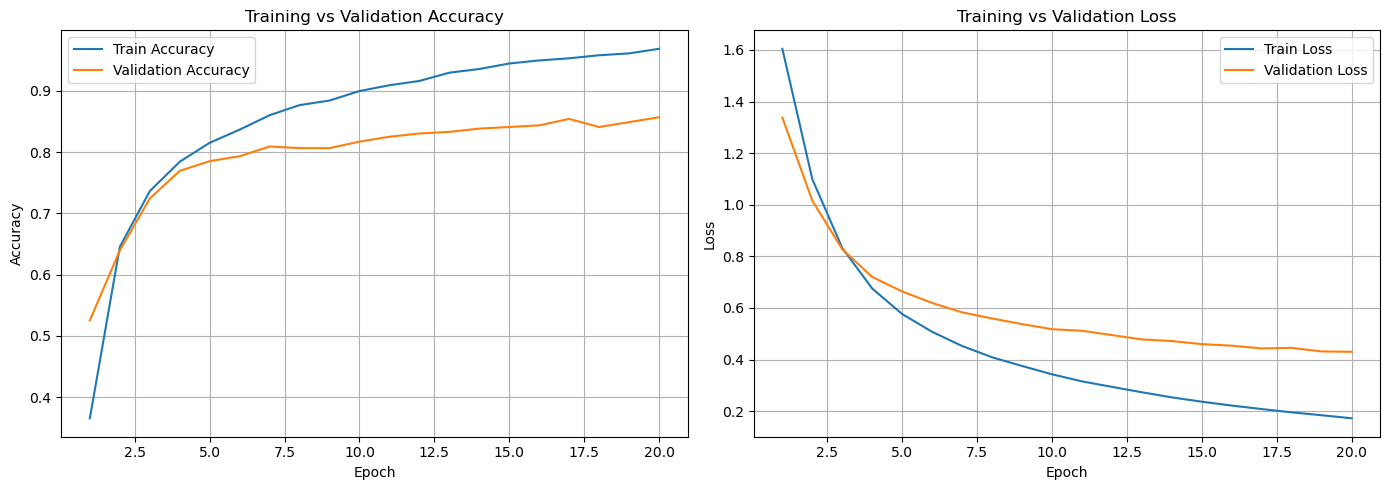

In [8]:
import matplotlib.pyplot as plt

# VISUALIZATION: ACCURACY & LOSS
epochs_range = range(1, len(history.history["loss"]) + 1)

plt.figure(figsize=(14, 5))

# ----- Accuracy Plot -----
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history["accuracy"])
plt.plot(epochs_range, history.history["val_accuracy"])
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.grid(True)

# ----- Loss Plot -----
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history["loss"])
plt.plot(epochs_range, history.history["val_loss"])
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Validation Loss"])
plt.grid(True)

plt.tight_layout()
plt.show()

In [9]:
# Waktu Inferensi Keseluruhan Test Set
start_time = time.time()

predictions = model.predict(test_data)

end_time = time.time()

inference_time_total = end_time - start_time
num_samples = test_data.samples

print(f"Total Inference Time (Test Set): {inference_time_total:.4f} seconds")
print(f"Average Inference Time per Image: {inference_time_total / num_samples:.6f} seconds")

12/12 [==============================] - 3s 154ms/step
Total Inference Time (Test Set): 2.9444 seconds
Average Inference Time per Image: 0.007688 seconds


In [10]:
# Evaluasi Model (Test Set – Tetap Sama)
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.4f}")

12/12 [==============================] - 2s 154ms/step - loss: 0.3900 - accuracy: 0.8512
Test Accuracy: 0.8512


In [11]:
# Ambil 1 batch
x_batch, _ = next(test_data)

# Warm-up (penting untuk CNN)
_ = model.predict(x_batch[:1])

start_time = time.time()
_ = model.predict(x_batch[:1])
end_time = time.time()

print(f"Inference Time (Single Image): {(end_time - start_time):.6f} seconds")

1/1 [==============================] - 0s 44ms/step
Inference Time (Single Image): 0.089493 seconds


In [12]:
# CONFUSION MATRIX & REPORT
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = test_data.classes
y_pred = np.argmax(model.predict(test_data), axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=CLASSES))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

12/12 [==============================] - 2s 151ms/step

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.93      0.84      0.88        61
       glass       0.84      0.88      0.86        76
       metal       0.84      0.84      0.84        62
       paper       0.86      0.91      0.89        90
     plastic       0.83      0.82      0.83        72
       trash       0.75      0.68      0.71        22

    accuracy                           0.85       383
   macro avg       0.84      0.83      0.83       383
weighted avg       0.85      0.85      0.85       383


Confusion Matrix:
[[51  1  0  8  0  1]
 [ 0 67  4  0  5  0]
 [ 0  3 52  4  2  1]
 [ 4  0  1 82  2  1]
 [ 0  7  4  0 59  2]
 [ 0  2  1  1  3 15]]


In [13]:
PRUNING_BASE_MODEL_PATH = "D:/KULIAH/SEMESTER 7/Skripsi/Dataset/mobilenetv3Large_trashnet_base"

model.save(
    PRUNING_BASE_MODEL_PATH,
    save_format="tf"
)

print(f"Model base untuk pruning disimpan di: {PRUNING_BASE_MODEL_PATH}")

INFO:tensorflow:Assets written to: D:/KULIAH/SEMESTER 7/Skripsi/Dataset/mobilenetv3Large_trashnet_base\assets


INFO:tensorflow:Assets written to: D:/KULIAH/SEMESTER 7/Skripsi/Dataset/mobilenetv3Large_trashnet_base\assets


Model base untuk pruning disimpan di: D:/KULIAH/SEMESTER 7/Skripsi/Dataset/mobilenetv3Large_trashnet_base
